# 🛍️ Project: Personalized E-commerce Recommendations

🎯 Project Goal
Build two predictive models to support a personalized recommendation system:
- **Model 1:** Predict Customer Segment (e.g., New Visitor, Occasional Shopper, Frequent Buyer) using customer demographics, browsing, and purchasing patterns.
- **Model 2:** Predict Probability of Recommendation for a product using its features and customer review data.

In [95]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error, top_k_accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

## Section 1. Load and clean data 

Objective:
- Load the datasets
- Understand structure, shape, and key variables

In [72]:
import kagglehub

path = kagglehub.dataset_download("suvroo/personalized-recommendations-for-e-commerce")

print("Path to dataset files:", path)

Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/suvroo/personalized-recommendations-for-e-commerce/versions/1


In [73]:
customer_data = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/customer_data_collection.csv')
product_data = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/product_recommendation_data.csv')

In [74]:
# Drop unnamed columns
customer_data.drop(columns=[col for col in customer_data.columns if "Unnamed" in col], inplace=True)
product_data.drop(columns=[col for col in product_data.columns if "Unnamed" in col], inplace=True)

# Section 2: Customer Data Preprocessing + Feature Engineering

Objective:
- Clean, encode, and split the customer data
- Prepare for classification task: predict Customer_Segment

In [75]:
print(customer_data.columns)

Index(['Customer_ID', 'Age', 'Gender', 'Location', 'Browsing_History',
       'Purchase_History', 'Customer_Segment', 'Avg_Order_Value', 'Holiday',
       'Season'],
      dtype='object')


In [76]:
# Drop rows with any remaining NaNs
customer_data.dropna(inplace=True)

In [77]:
customer_data.drop(columns=["Customer_ID"], inplace=True, errors="ignore")
customer_data["Browsing_History"] = customer_data["Browsing_History"].apply(ast.literal_eval)
customer_data["Purchase_History"] = customer_data["Purchase_History"].apply(ast.literal_eval)

# Feature engineering
customer_data["Num_Browsed"] = customer_data["Browsing_History"].apply(len)
customer_data["Unique_Browsed"] = customer_data["Browsing_History"].apply(lambda x: len(set(x)))
customer_data["Num_Purchased"] = customer_data["Purchase_History"].apply(len)

customer_data["Browsing_Str"] = customer_data["Browsing_History"].apply(lambda x: ' '.join(x))
customer_data["Purchase_Str"] = customer_data["Purchase_History"].apply(lambda x: ' '.join(x))

browse_vect = CountVectorizer(max_features=20)
purchase_vect = CountVectorizer(max_features=20)
X_browse = browse_vect.fit_transform(customer_data["Browsing_Str"]).toarray()
X_purchase = purchase_vect.fit_transform(customer_data["Purchase_Str"]).toarray()

browse_df = pd.DataFrame(X_browse, columns=[f"Browse_{w}" for w in browse_vect.get_feature_names_out()])
purchase_df = pd.DataFrame(X_purchase, columns=[f"Purchase_{w}" for w in purchase_vect.get_feature_names_out()])

customer_data = pd.concat([customer_data, browse_df, purchase_df], axis=1)
customer_data.drop(columns=["Browsing_History", "Purchase_History", "Browsing_Str", "Purchase_Str"], inplace=True)
customer_data = pd.get_dummies(customer_data, columns=["Gender", "Location", "Holiday", "Season"])
customer_data.dropna(inplace=True)

X_customer = customer_data.drop(columns=["Customer_Segment"])
y_customer = LabelEncoder().fit_transform(customer_data["Customer_Segment"])

In [78]:
# SECTION 2.1: Address Class Imbalance with SMOTE

smote = SMOTE(random_state=42)
X_customer_bal, y_customer_bal = smote.fit_resample(X_customer, y_customer)
X_train_cust, X_test_cust, y_train_cust, y_test_cust = train_test_split(X_customer_bal, y_customer_bal, test_size=0.2, stratify=y_customer_bal, random_state=42)


# Section 3: Product Data Preprocessing

Objective:
- Clean, encode, and split product data
- Prepare for regression task: predict Probability_of_Recommendation

In [52]:
product_data.drop(columns=["Product_ID", "Similar_Product_List"], inplace=True)
product_data = pd.get_dummies(product_data, columns=["Category", "Subcategory", "Brand", "Holiday", "Season", "Geographical_Location"])

X_product = product_data.drop(columns=["Probability_of_Recommendation"])
y_product = product_data["Probability_of_Recommendation"]
X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(X_product, y_product, test_size=0.2, random_state=42)

In [53]:
# Drop rows with any remaining NaNs
product_data.dropna(inplace=True)

# Section 4: Classification Model (Customer Segment)

Predict Customer Segment 

Goal: Classify users as New Visitor, Occasional Shopper, or Frequent Buyer

In [79]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=30, class_weight='balanced', random_state=42)
log_clf = LogisticRegression(max_iter=1000, random_state=42)
gb_clf = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('lr', log_clf),
    ('gb', gb_clf)
], voting='soft')

voting_clf.fit(X_train_cust, y_train_cust)
y_pred_ensemble = voting_clf.predict(X_test_cust)

print("\nEnsemble Accuracy (Top-1):", accuracy_score(y_test_cust, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test_cust, y_pred_ensemble))

proba_preds = voting_clf.predict_proba(X_test_cust)
top2_accuracy = top_k_accuracy_score(y_test_cust, proba_preds, k=2)
print("Top-2 Accuracy:", top2_accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Ensemble Accuracy (Top-1): 0.3482979773063641
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.35      0.36       675
           1       0.34      0.36      0.35       676
           2       0.33      0.33      0.33       676

    accuracy                           0.35      2027
   macro avg       0.35      0.35      0.35      2027
weighted avg       0.35      0.35      0.35      2027

Top-2 Accuracy: 0.6788357178095707


# Section 4.1: Feature Importance Plot 

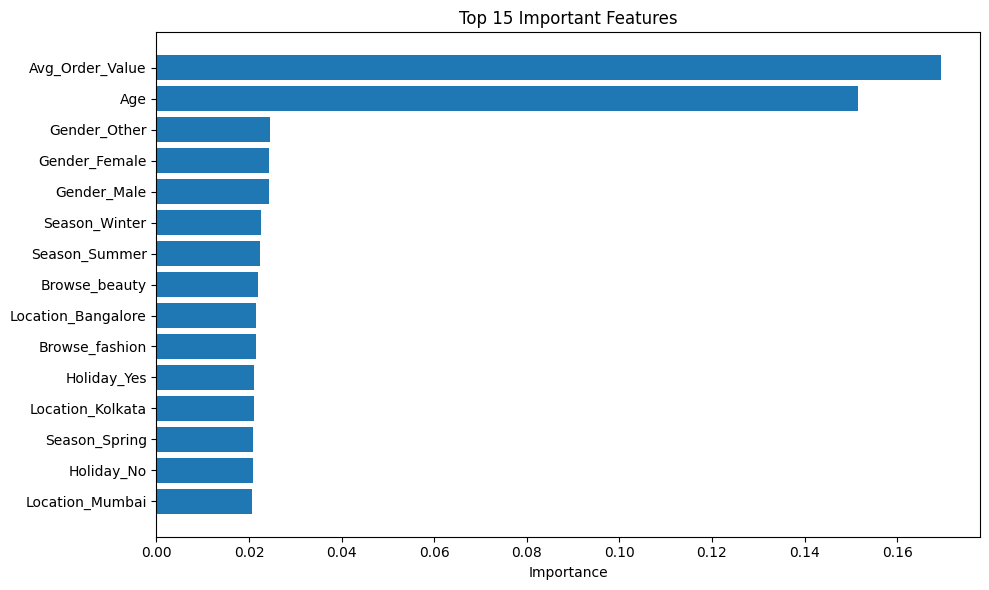

In [80]:
feature_importances = rf_clf.fit(X_train_cust, y_train_cust).feature_importances_
indices = np.argsort(feature_importances)[-15:][::-1]
features = X_customer.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Important Features")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), features)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Section 4.2: Predict Segment for New Customers

Objective:
- Demonstrate how to use trained model (Random Forest) to predict customer segments
  for new/unseen customer profiles

In [81]:
sample_indices = X_customer.sample(5, random_state=42).index
new_customers = X_customer.loc[sample_indices]
true_segments = y_customer[sample_indices]

segment_predictions = rf_clf.predict(new_customers)
label_encoder = LabelEncoder().fit(customer_data["Customer_Segment"])
predicted_labels = label_encoder.inverse_transform(segment_predictions)
true_labels = label_encoder.inverse_transform(true_segments)

print("\nPredicted vs Actual Customer Segments:")
for i in range(len(sample_indices)):
    print(f"Customer {i+1}: Predicted = {predicted_labels[i]} | Actual = {true_labels[i]}")


Predicted vs Actual Customer Segments:
Customer 1: Predicted = Occasional Shopper | Actual = Occasional Shopper
Customer 2: Predicted = New Visitor | Actual = New Visitor
Customer 3: Predicted = Frequent Buyer | Actual = Frequent Buyer
Customer 4: Predicted = New Visitor | Actual = New Visitor
Customer 5: Predicted = Frequent Buyer | Actual = Frequent Buyer


# Section 5: Product Recommendation Model Selection 

# 5.1 XGBRegressor 

In [96]:
# Feature Scaling + XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [97]:
# Fit the pipeline to training data
xgb_pipeline.fit(X_train_prod, y_train_prod)

# Predict on test set
y_pred_xgb = xgb_pipeline.predict(X_test_prod)

# Evaluate XGBoost performance
print("\nXGBoost Regressor")
print("R²:", r2_score(y_test_prod, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test_prod, y_pred_xgb)))


XGBoost Regressor
R²: -0.03904526097056027
RMSE: 0.26433210352803493


In [98]:
# Cross-validated performance
cv_r2_xgb = cross_val_score(xgb_pipeline, X_product, y_product, cv=5, scoring='r2')
cv_rmse_xgb = cross_val_score(
    xgb_pipeline, X_product, y_product, cv=5,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

print("\nCross-Validated R² Scores (XGBoost):", cv_r2_xgb)
print("Average R²:", np.mean(cv_r2_xgb))
print("Average RMSE:", np.sqrt(-np.mean(cv_rmse_xgb)))


Cross-Validated R² Scores (XGBoost): [-0.02488053 -0.03192161 -0.0246115  -0.0465736  -0.05371449]
Average R²: -0.03634034542668156
Average RMSE: 0.26472864507117666


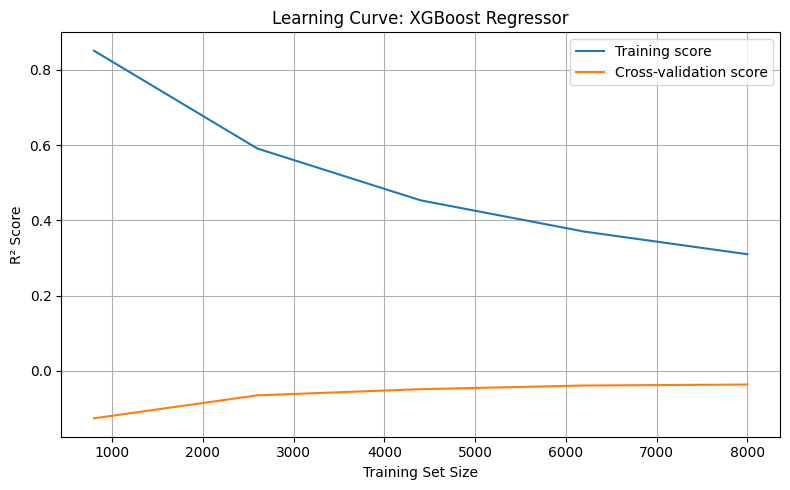

In [99]:
# Plot updated learning curve for XGBoost
train_sizes, train_scores, test_scores = learning_curve(
    xgb_pipeline, X_product, y_product, cv=5, scoring='r2', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.title("Learning Curve: XGBoost Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
# Predict recommendation probability for new samples
sample_indices_prod = X_product.sample(5, random_state=42).index
new_products = X_product.loc[sample_indices_prod]
true_scores = y_product[sample_indices_prod]
predicted_scores = xgb_pipeline.predict(new_products)

print("\nPredicted vs Actual Product Recommendation Scores (XGBoost):")
for i in range(len(sample_indices_prod)):
    print(f"Product {i+1}: Predicted = {predicted_scores[i]:.2f} | Actual = {true_scores.iloc[i]:.2f}")


Predicted vs Actual Product Recommendation Scores (XGBoost):
Product 1: Predicted = 0.58 | Actual = 0.98
Product 2: Predicted = 0.55 | Actual = 0.67
Product 3: Predicted = 0.49 | Actual = 0.28
Product 4: Predicted = 0.54 | Actual = 0.45
Product 5: Predicted = 0.51 | Actual = 0.70


# 5.2 RandomForestRegressor 
GridSearchCV: for hyperparameter tuning of the Random Forest Regressor. 

In [83]:
# GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_reg = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf_reg, param_grid, cv=5, scoring='r2')
grid_rf.fit(X_train_prod, y_train_prod)
best_rf = grid_rf.best_estimator_

In [86]:
# Fit baseline Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prod, y_train_prod)

# Evaluate both models
for name, model in zip(['Random Forest Regressor', 'Linear Regression'], [best_rf, lin_reg]):
    y_pred = model.predict(X_test_prod)
    print(f"\n{name}")
    print("R²:", r2_score(y_test_prod, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test_prod, y_pred)))


Random Forest Regressor
R²: -0.011678462772009235
RMSE: 0.26082783190629005

Linear Regression
R²: -0.0074120026139199435
RMSE: 0.2602772680096168


In [89]:
# Cross-validation
r2_scores = cross_val_score(best_rf, X_product, y_product, cv=5, scoring='r2')
rmse_scores = cross_val_score(best_rf, X_product, y_product, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))
print("\nCross-Validated R² Scores:", r2_scores)
print("Average R²:", np.mean(r2_scores))
print("Average RMSE:", np.sqrt(-np.mean(rmse_scores)))



Cross-Validated R² Scores: [-0.00696545 -0.00997072 -0.00490071 -0.01344484 -0.01261002]
Average R²: -0.009578348842220752
Average RMSE: 0.26128148765873865


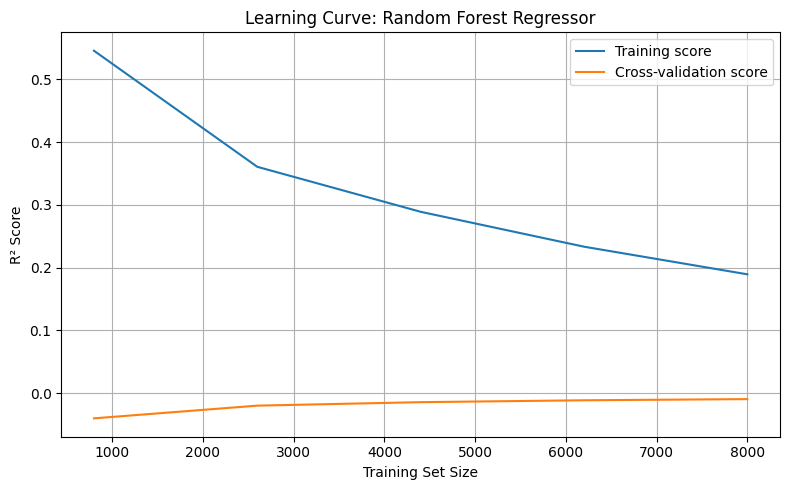

In [90]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_product, y_product, cv=5, scoring='r2', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.title("Learning Curve: Random Forest Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# Predict recommendation probability for new samples
sample_indices_prod = X_product.sample(5, random_state=42).index
new_products = X_product.loc[sample_indices_prod]
true_scores = y_product[sample_indices_prod]
predicted_scores = best_rf.predict(new_products)

print("\nPredicted vs Actual Product Recommendation Scores:")
for i in range(len(sample_indices_prod)):
    print(f"Product {i+1}: Predicted = {predicted_scores[i]:.2f} | Actual = {true_scores.iloc[i]:.2f}")


Predicted vs Actual Product Recommendation Scores:
Product 1: Predicted = 0.55 | Actual = 0.98
Product 2: Predicted = 0.56 | Actual = 0.67
Product 3: Predicted = 0.53 | Actual = 0.28
Product 4: Predicted = 0.56 | Actual = 0.45
Product 5: Predicted = 0.54 | Actual = 0.70
